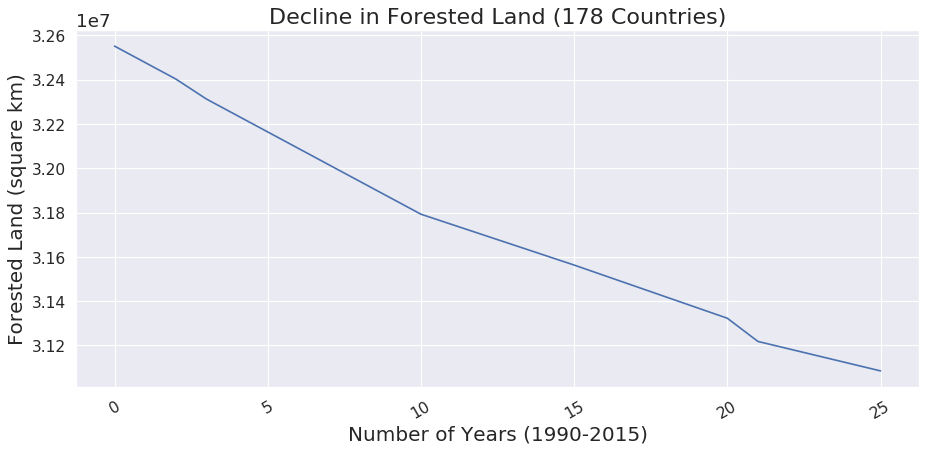

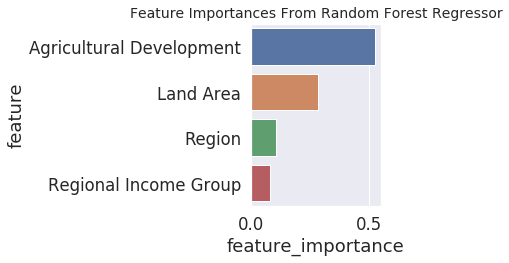

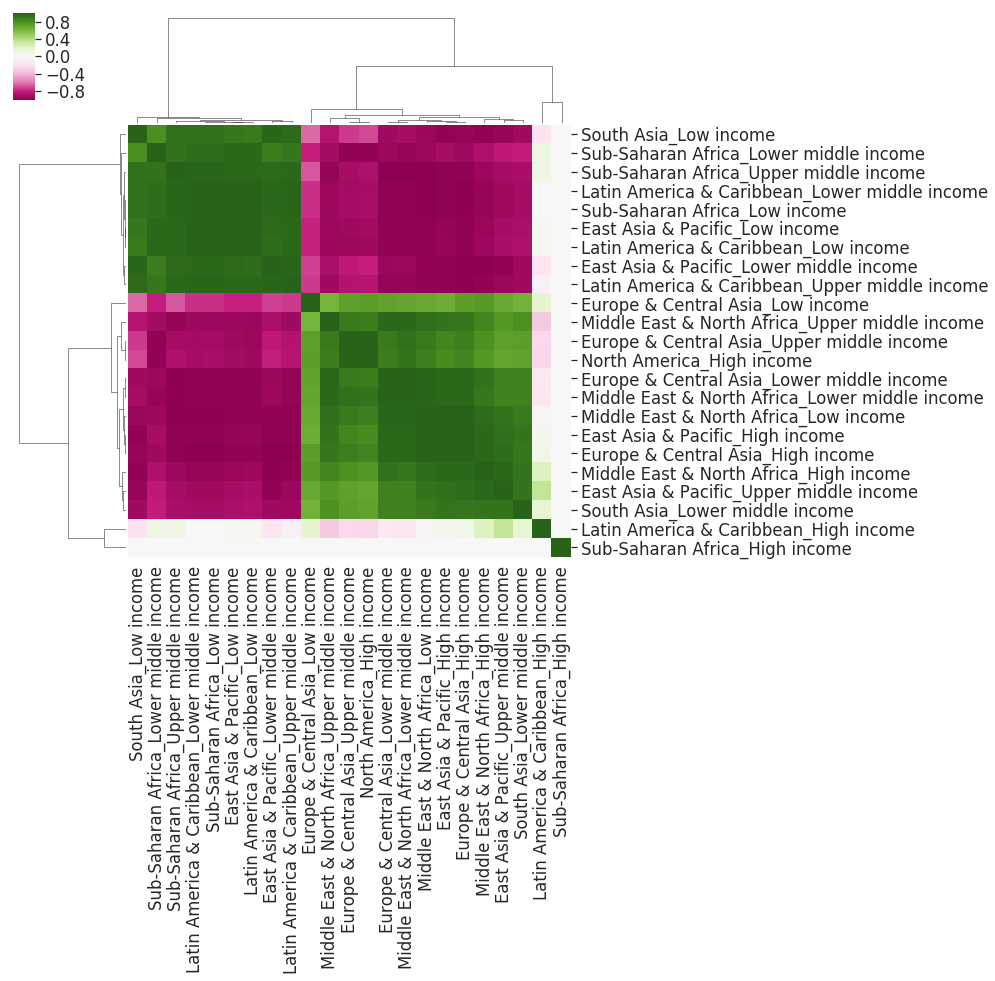

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

#only works on categorical columns
def mapEncode(df,col):
    init_vals = df[col].values
    vals2int = dict(zip(init_vals,list(range(len(init_vals)))))
    newvals=[]
    for i in init_vals:
        newvals.append(vals2int[i])
    df[col+"_encoded"] = newvals
    return(df)

def ts_summary(df):
    forestation_cols = [c for c in df.columns if ("forestation" in c)]
    land_area = [c for c in df.columns if ("land_area" in c)] 
    agriculture = [c for c in df.columns if ("agriculture" in c)]
    all_cols = forestation_cols+land_area+agriculture

    df["land_mean"] = df[land_area].apply(np.mean,axis=1).values

    agvals = df[agriculture].values
    df["agriculture_slope"] = (agvals[:,-1]-agvals[:,0])/float(len(agriculture))

    forestvals = df[forestation_cols].values
    df["forestation_slope"] = (forestvals[:,-1]-forestvals[:,0])/float(len(forestation_cols))
    return(df,all_cols)
    
def plot_deforestation_data(merged):

    plot_df_forestation = merged[[c for c in merged.columns if ("forestation" in c)]]
    plot_df_land = merged[[c for c in merged.columns if ("land_area" in c)]]
    #rearrange for seaborn
    vals = np.sum(((plot_df_forestation.values/100.0) * plot_df_land.values.astype(np.float64)),axis=0)
    plt.plot(vals)
    #plt.ticklabel_format(useOffset=True)
    plt.title("Decline in Forested Land (178 Countries)",fontsize=20)
    plt.xticks(fontsize=14, rotation=30)
    plt.yticks(fontsize=14, rotation=0)
    plt.ylabel("Forested Land (square km)",fontsize=18)
    plt.xlabel("Number of Years (1990-2015)",fontsize=18)
    plt.tight_layout()
    plt.show()
    plt.close()


def plot_feature_importances(merged):
    #fit Random forest model 
    model = RandomForestRegressor(n_estimators=100)
    y = merged["forestation_slope"].values
    merged.drop("forestation_slope",axis=1,inplace=True)
    X = merged[merged.columns[2:]].values
    model.fit(X,y)
    imp = model.feature_importances_

    feature_importances_out = pd.DataFrame(imp,columns=["feature_importance"])
    feature_importances_out.insert(0,"feature",merged.columns[2:])
    feature_importances_out.sort_values("feature_importance",ascending=False,inplace=True)

    feature_importances_out["feature"] = ["Agricultural Development","Land Area","Region","Regional Income Group"]
    sns.set(font_scale = 1.5)
    ax = sns.barplot(x="feature_importance", y="feature", data=feature_importances_out)
    plt.title("Feature Importances From Random Forest Regressor",fontsize=14)
    plt.tight_layout()
    plt.show()
    plt.close()

def plotClustermap():
	df_forestation = pd.read_csv("data/percent_forestation.csv")
	df_region = pd.read_csv("data/region_and_income.csv")
	code2name = dict(zip(list(df_forestation["Country Code"].values),list(df_forestation["Country Name"].values)))

	df_forestation.index = df_forestation["Country Code"].values
	df_region.index = df_region["Country Code"].values

	df_forestation = df_forestation[df_forestation.columns[4:]]
	df_region = df_region[["Region","IncomeGroup"]]
	merged = pd.concat([df_region,df_forestation],axis=1,sort=False)
	merged.dropna(how="any",inplace=True,axis=0)
	merged = merged.groupby(["Region","IncomeGroup"]).mean()
	merged.sort_values(["Region","IncomeGroup"],inplace=True)

	newindex=[]
	for pair in merged.index.values:
	    newindex.append(pair[0]+"_"+pair[1])
	merged.index = newindex
	merged.drop("South Asia_Upper middle income",axis=0,inplace=True)
	corr = merged.transpose().corr()

	merged.to_csv("testout.csv")


	newdf = pd.DataFrame(data=corr,columns=merged.index.values)
	newdf.index = merged.index.values


	g = sns.clustermap(newdf,row_cluster=True, cbar_kws=None, col_cluster=True, row_linkage=None,cmap="PiYG", col_linkage=None, robust=True,vmin=-1, vmax=1)
	plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

	plt.show()
	#plt.savefig("figures/clustermap.png",bbox_inches='tight')
	plt.close()



def rename_cols(all_dfs):
    for e in all_dfs:
        df = all_dfs[e]
        df.index = df["Country Code"].values
        df.drop("Country Code",axis=1,inplace=True)
        if ("Country Name" in df.columns):
            df.drop("Country Name",axis=1,inplace=True)
        df.columns = [c+"_"+e for c in df.columns]
        all_dfs[e] = df
    return(all_dfs)

def prune_perc_forestation(all_dfs,dates):
    df = all_dfs["forestation"]
    df = df[[c for d in dates for c in df.columns if (d in c)]]
    all_dfs["forestation"] = df
    return(all_dfs)

def prune_land_area(all_dfs,dates):
    df = all_dfs["land_area"]
    df = df[[c for d in dates for c in df.columns if (d in c)]]
    all_dfs["land_area"] = df
    return(all_dfs)

def prune_agriculture(all_dfs,dates):
    df = all_dfs["agriculture"]
    df = df[[c for d in dates for c in df.columns if (d in c)]]
    all_dfs["agriculture"] = df
    return(all_dfs)

def prune_regional_income(all_dfs):
    df = all_dfs["region_income"]
    df = df[["Region_region_income","IncomeGroup_region_income"]]
    all_dfs["region_income"] = df
    return(all_dfs)



#combine all data into a single table
df_perc_forestation = pd.read_csv('data/percent_forestation.csv')
df_agriculture = pd.read_csv('data/agricultural_land_perc.csv')
df_land_area = pd.read_csv('data/land_area.csv')
df_region_income = pd.read_csv("data/region_and_income.csv")
country_name_to_code = dict(zip(list(df_perc_forestation["Country Name"].values),list(df_perc_forestation["Country Code"].values)))
all_dfs = {"forestation":df_perc_forestation,"agriculture":df_agriculture,"land_area":df_land_area,"region_income":df_region_income}

#rename columns and drop ones we don't want
all_dfs = rename_cols(all_dfs)

dates = [str(d) for d in range(1990,2016)]
all_dfs = prune_perc_forestation(all_dfs,dates)
all_dfs = prune_land_area(all_dfs,dates)
all_dfs = prune_agriculture(all_dfs,dates)
all_dfs = prune_regional_income(all_dfs)

merged = pd.concat(all_dfs.values(),axis=1,sort=False)
#only retain complete data
merged.dropna(how="any",axis=0,inplace=True)
plot_deforestation_data(merged) #plot basic deforestation median as in sqare kilometers

#use simple map encoding for remaining categorical column
merged = mapEncode(merged,"Region_region_income")
merged = mapEncode(merged,"IncomeGroup_region_income")

#calculate a summary statistic for the time series <can improve a lot on this>
merged,summarized_cols = ts_summary(merged)
merged.drop(summarized_cols,axis=1,inplace=True)
plot_feature_importances(merged)

#try to visualize relationship between income, region, and deforestation
plotClustermap()

